# Pricing CDS Options

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  copy import deepcopy as copy
from datetime import datetime
import datetime
import warnings
import os
import tqdm as tq
import functools
import time
from scipy.interpolate import interp1d
from scipy.special import legendre # For Legendre polynomials
from scipy.integrate import quad
from scipy.linalg import expm, inv
from math import comb
from numpy.polynomial.legendre import leg2poly

## Parameter Setting

In [185]:
#Model Parameters
gamma = 0.25
l1 = 0.05
l2 = 1.0
sigma = 0.75
r = 0.0  
delta=0.4 #recovery rate
payment_interval = 0.25

#Initial Condition
X0 = 0.2
Y0 = 1.0 

#option Parameters
t0 = 1.0  #option maturity
tM = t0 + 5.0 #maturity of underlying CDS
# Strike spreads in basis points, convert to decimal
strikes_bps = [250, 300, 350]
strikes = [k / 10000.0 for k in strikes_bps]

#Polynomial order
N_orders = range(1, 31) 

## Key Functions

### Calculation of Psi

In [186]:
def calculate_psi_vectors(t, t_M):
    """
    Calculates the core pricing vectors psi_Z, psi_D, and psi_D_star.
    
    Args:
        t (float): Current time.
        t_M (float): Maturity time.

    Returns:
        tuple: (psi_Z, psi_D, psi_D_star) as column vectors (numpy arrays).
    """
    

    # To match the intensity drift factorization (λ-l1)(λ-l2) = λ^2 - (l1+l2)λ + l1l2
    # with the drift derived from dX_t, which is λ^2 + βλ + bγ, we must have:
    # β = -(l1+l2)
    # bγ = l1l2  =>  b = (l1*l2)/gamma
    # Define the A_star matrix
    beta = -(l1 + l2)
    b = (l1 * l2) / gamma

    A = np.array([
    [0, -gamma],  
    [b, beta]     
    ])
    a = np.array([1.0])
    A_star = A - r * np.eye(2)

    T = t_M - t # Time to maturity
    
    # Calculate matrix exponential
    exp_A_T = expm(A * T)
    exp_A_star_T = expm(A_star * T)
    
    # Check if A_star is invertible
    try:
        inv_A_star = inv(A_star)
    except np.linalg.LinAlgError:
        raise ValueError("A_star matrix is singular, cannot use closed-form integral formulas.")

    # 1. Calculate psi_Z
    a_vec_T = np.array([1, 0])
    psi_Z_T = np.exp(-r * T) * (a_vec_T @ exp_A_T)
    psi_Z = psi_Z_T.reshape(-1, 1)

    # 2. Calculate psi_D
    c = 0.0  # c=0 from dY_t = (c Y_t + gamma X_t) dt
    c_gamma = np.array([c, -gamma]) #[c, gamma]
    I = np.identity(2)
    integral_exp = inv_A_star @ (exp_A_star_T - I)
    psi_D_T = -c_gamma @ integral_exp
    psi_D = psi_D_T.reshape(-1, 1)
 
    # 3. Calculate psi_D_star
    # Integral of u*exp(A*u) from 0 to T
    term1 = T * inv_A_star @ expm(A_star * T)
    term2 = inv_A_star @ (t * I - inv_A_star) @ (expm(A_star * T) - I)
    psi_D_star_T = -(c_gamma @ (term1 + term2)) 
    psi_D_star = psi_D_star_T.reshape(-1, 1)

    return psi_Z, psi_D, psi_D_star

In [187]:
t = 0.0
t_M = 5.0

psi_Z, psi_D, psi_D_star = calculate_psi_vectors(t, t_M)

print(psi_Z, psi_D, psi_D_star)

[[ 0.81943567]
 [-0.20317443]] [[0.18056433]
 [0.20317443]] [[0.50737032]
 [0.1130505 ]]


### Calculate Interval [b_min, b_max]

In [188]:
def calculate_cds_payoff_bounds(strike, t0, t_M):
    """
    Calculates the bounds [b_min, b_max] for the payoff random variable Z,
    and the payoff vector psi_cds.

    Args:
        strike (float): Strike spread of the CDS option (as a decimal).
        t0 (float): Option maturity.
        t_M (float): Underlying CDS maturity.

    Returns:
        tuple: (b_min, b_max, psi_cds).
    """
    psi_Z, psi_D, psi_D_star = calculate_psi_vectors(t0, tM)

    # 1. Calculate psi_prot
    # Protection leg pays (1-delta) if default occurs between t0 and t_M.
    psi_prot = (1 - delta) * (psi_D - calculate_psi_vectors(t0, t0)[1])
    
    # 2. Calculate psi_prem
    # Premium leg is the sum of coupon payments and accrued interest.
    
    # tenor structure for the underlying CDS.
    tenor_dates = np.arange(t0 + payment_interval, t_M + 1e-6, payment_interval)
    all_dates = np.insert(tenor_dates, 0, t0) # Full set of dates including t0

    # Coupon part (V_coup)
    psi_coup = np.zeros((2, 1))
    for t_j in tenor_dates:
        # For each payment date t_j, we need the price of a zero-coupon bond B_Z(t0, t_j)
        psi_Z_t0_tj, _, _ = calculate_psi_vectors(t0, t_j)
        psi_coup += payment_interval * psi_Z_t0_tj
        
    # Accrued interest part (V_ai)
    # From Prop 2.9: V_ai(t0,t0,t_M) = CD*(t0,t_M) - Sum_{j=1..M} t_{j-1} * (CD(t0,t_j) - CD(t0,t_{j-1}))
    psi_ai = np.zeros((2, 1))
    _, _, psi_D_star_t0_tM = calculate_psi_vectors(t0, t_M)
    psi_ai += psi_D_star_t0_tM # First term: CD*(t0, t_M)
    
    # Loop over payment periods to subtract the summation term
    for i in range(len(all_dates) - 1):
        t_j_minus_1 = all_dates[i]
        t_j = all_dates[i+1]
        
        # We need CD(t0, t_j) and CD(t0, t_{j-1})
        _, psi_D_t0_tj, _ = calculate_psi_vectors(t0, t_j)
        _, psi_D_t0_tj_minus_1, _ = calculate_psi_vectors(t0, t_j_minus_1)
        
        psi_ai -= t_j_minus_1 * (psi_D_t0_tj - psi_D_t0_tj_minus_1)

    psi_prem = psi_coup + psi_ai
    
    # 3. Calculate psi_cds
    psi_cds = psi_prot - strike * psi_prem
    
    # 4. Calculate bounds [b_min, b_max]
    psi1 = psi_cds[0, 0]
    psi2 = psi_cds[1, 0]
    
    b_max = max(0, psi1) + max(0, psi2)
    b_min = min(0, psi1) + min(0, psi2)

    return b_min, b_max, psi_cds

In [189]:
for i, k_bps in enumerate(strikes_bps):
    strike_dec = strikes[i]
    
    b_min_val, b_max_val, psi_cds_vec_val = calculate_cds_payoff_bounds(
        strike=strike_dec,
        t0=t0,
        t_M=tM
    )
    
    print(f"\n--- For a strike of {k_bps} bps ({strike_dec}) ---")
    print(f"psi_cds vector:\n{psi_cds_vec_val}")
    print(f"Payoff bounds: [b_min, b_max] = [{b_min_val:.4f}, {b_max_val:.4f}]")



--- For a strike of 250 bps (0.025) ---
psi_cds vector:
[[-0.00677512]
 [ 0.1444752 ]]
Payoff bounds: [b_min, b_max] = [-0.0068, 0.1445]

--- For a strike of 300 bps (0.03) ---
psi_cds vector:
[[-0.02979786]
 [ 0.14898931]]
Payoff bounds: [b_min, b_max] = [-0.0298, 0.1490]

--- For a strike of 350 bps (0.035) ---
psi_cds vector:
[[-0.0528206 ]
 [ 0.15350342]]
Payoff bounds: [b_min, b_max] = [-0.0528, 0.1535]


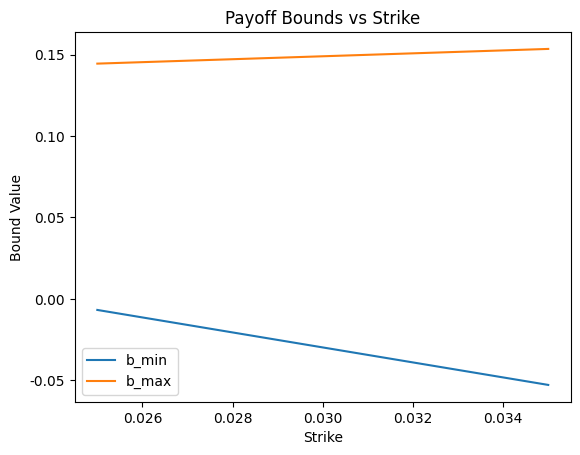

In [190]:
b_mins = []
b_maxs = []
for k in strikes:
    b_min, b_max, _ = calculate_cds_payoff_bounds(k, 1.0, 6.0)
    b_mins.append(b_min)
    b_maxs.append(b_max)

plt.plot(strikes, b_mins, label='b_min')
plt.plot(strikes, b_maxs, label='b_max')
plt.xlabel('Strike')
plt.ylabel('Bound Value')
plt.legend()
plt.title('Payoff Bounds vs Strike')
plt.show()


## Fourier-Legendre

In [191]:
def generalized_legendre_poly(n, z, bounds):
    """
    Calculates the value of the nth generalized Legendre polynomial at point z,
    defined on the interval specified by bounds.

    Args:
        n (int): Order of the polynomial.
        z (float or np.ndarray): Point(s) to evaluate the polynomial at.
        bounds (tuple): A tuple (b_min, b_max) defining the interval.

    Returns:
        float or np.ndarray: The value of the polynomial at z.
    """
    b_min, b_max = bounds
    
    # Avoid division by zero if the interval is a single point
    if b_max == b_min:
        if n == 0:
            return 1.0
        else:
            return 0.0

    # Map z from [b_min, b_max] to x in [-1, 1]
    x = (2 * z - (b_max + b_min)) / (b_max - b_min)
    
    # Get the standard Legendre polynomial of order n
    Pn = legendre(n)
    
    # Evaluate it at the mapped coordinate(s) x
    return Pn(x)

In [192]:

def calculate_fourier_legendre_coeff(n, bounds):
    """
    Calculates the nth Fourier-Legendre coefficient for the payoff f(z) = max(z, 0).

    Args:
        n (int): The order of the coefficient.
        bounds (tuple): A tuple (b_min, b_max) defining the interval.

    Returns:
        float: The value of the coefficient f_n.
    """
    b_min, b_max = bounds

    # Avoid division by zero
    if b_max == b_min:
        return 0.0
    
    # The normalization constant for Legendre polynomials on [a, b] is (2n+1)/(b-a)
    normalization_const = (2 * n + 1) / (b_max - b_min)
    
    # The integrand is f(z) * Le_n(z), where f(z) = max(z,0) and Le_n is the generalized Legendre polynomial
    integrand = lambda z: np.maximum(0, z) * generalized_legendre_poly(n, z, bounds)
    
    # The integration is over the entire interval [b_min, b_max]
    # The max(0, z) in the integrand handles the case where z is negative.
    result, error = quad(integrand, b_min, b_max, limit=200) # Increased limit for accuracy

    # The final coefficient is the integral multiplied by the normalization constant
    f_n = normalization_const * result
    
    return f_n

In [193]:
def approximate_payoff(z_values, n_order, bounds):
    """
    Approximates the payoff function f(z) = max(z, 0) using an n-order
    Fourier-Legendre series expansion.

    Args:
        z_values (np.ndarray): Array of z-points to evaluate the approximation at.
        n_order (int): The order of the polynomial approximation.
        bounds (tuple): A tuple (b_min, b_max) defining the interval.

    Returns:
        np.ndarray: The approximated payoff values at z_values.
    """
    # First, calculate all the required coefficients from order 0 to n_order
    coeffs = [calculate_fourier_legendre_coeff(i, bounds) for i in range(n_order + 1)]
    
    # Initialize the sum of the series to zero
    series_sum = np.zeros_like(z_values, dtype=float)
    
    # Sum the series: f_i * Le_i(z)
    for i, f_i in enumerate(coeffs):
        series_sum += f_i * generalized_legendre_poly(i, z_values, bounds)
        
    return series_sum

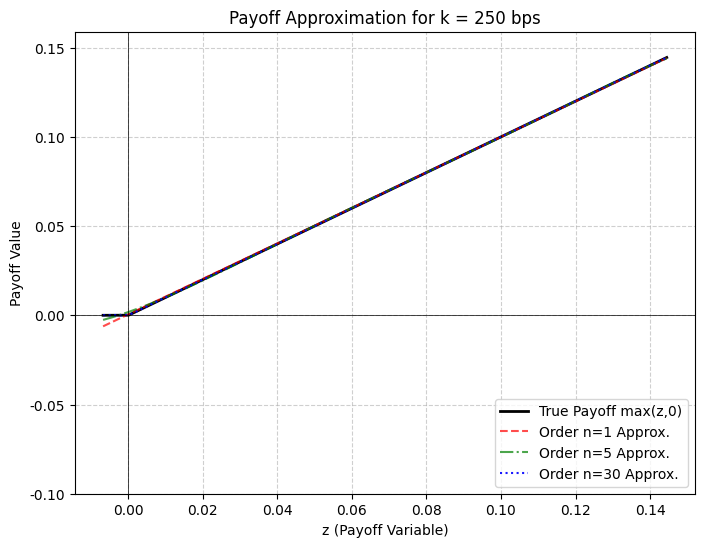

In [194]:
# --- Verification for Fourier-Legendre Approximation ---

# Choose one strike for plotting
strike_to_plot_bps = 250
strike_to_plot_dec = strike_to_plot_bps / 10000.0

# 1. Get the bounds for this strike
b_min_plot, b_max_plot, _ = calculate_cds_payoff_bounds(
    strike=strike_to_plot_dec,
    t0=t0,
    t_M=tM
)
plot_bounds = (b_min_plot, b_max_plot)

# 2. Create a grid of z-points for plotting
z_grid = np.linspace(b_min_plot, b_max_plot, 400)

# 3. Calculate the true payoff
true_payoff = np.maximum(0, z_grid)

# 4. Calculate approximations for different orders
approx_n1 = approximate_payoff(z_grid, 1, plot_bounds)
approx_n5 = approximate_payoff(z_grid, 5, plot_bounds)
approx_n30 = approximate_payoff(z_grid, 30, plot_bounds)

# 5. Plot the results
plt.figure(figsize=(8, 6))
plt.title(f"Payoff Approximation for k = {strike_to_plot_bps} bps")
plt.plot(z_grid, true_payoff, 'k-', label='True Payoff max(z,0)', linewidth=2)
plt.plot(z_grid, approx_n1, 'r--', label='Order n=1 Approx.', alpha=0.7)
plt.plot(z_grid, approx_n5, 'g-.', label='Order n=5 Approx.', alpha=0.7)
plt.plot(z_grid, approx_n30, 'b:', label='Order n=30 Approx.', alpha=0.9)

plt.xlabel("z (Payoff Variable)")
plt.ylabel("Payoff Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.ylim(min(b_min_plot, -0.1), b_max_plot * 1.1) # Adjust y-limits for better view
plt.show()

Calculating Fourier-Legendre error bounds for k = 250 bps...


n for k=250: 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


Calculating Fourier-Legendre error bounds for k = 300 bps...


n for k=300: 100%|██████████| 30/30 [00:18<00:00,  1.60it/s]


Calculating Fourier-Legendre error bounds for k = 350 bps...


n for k=350: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


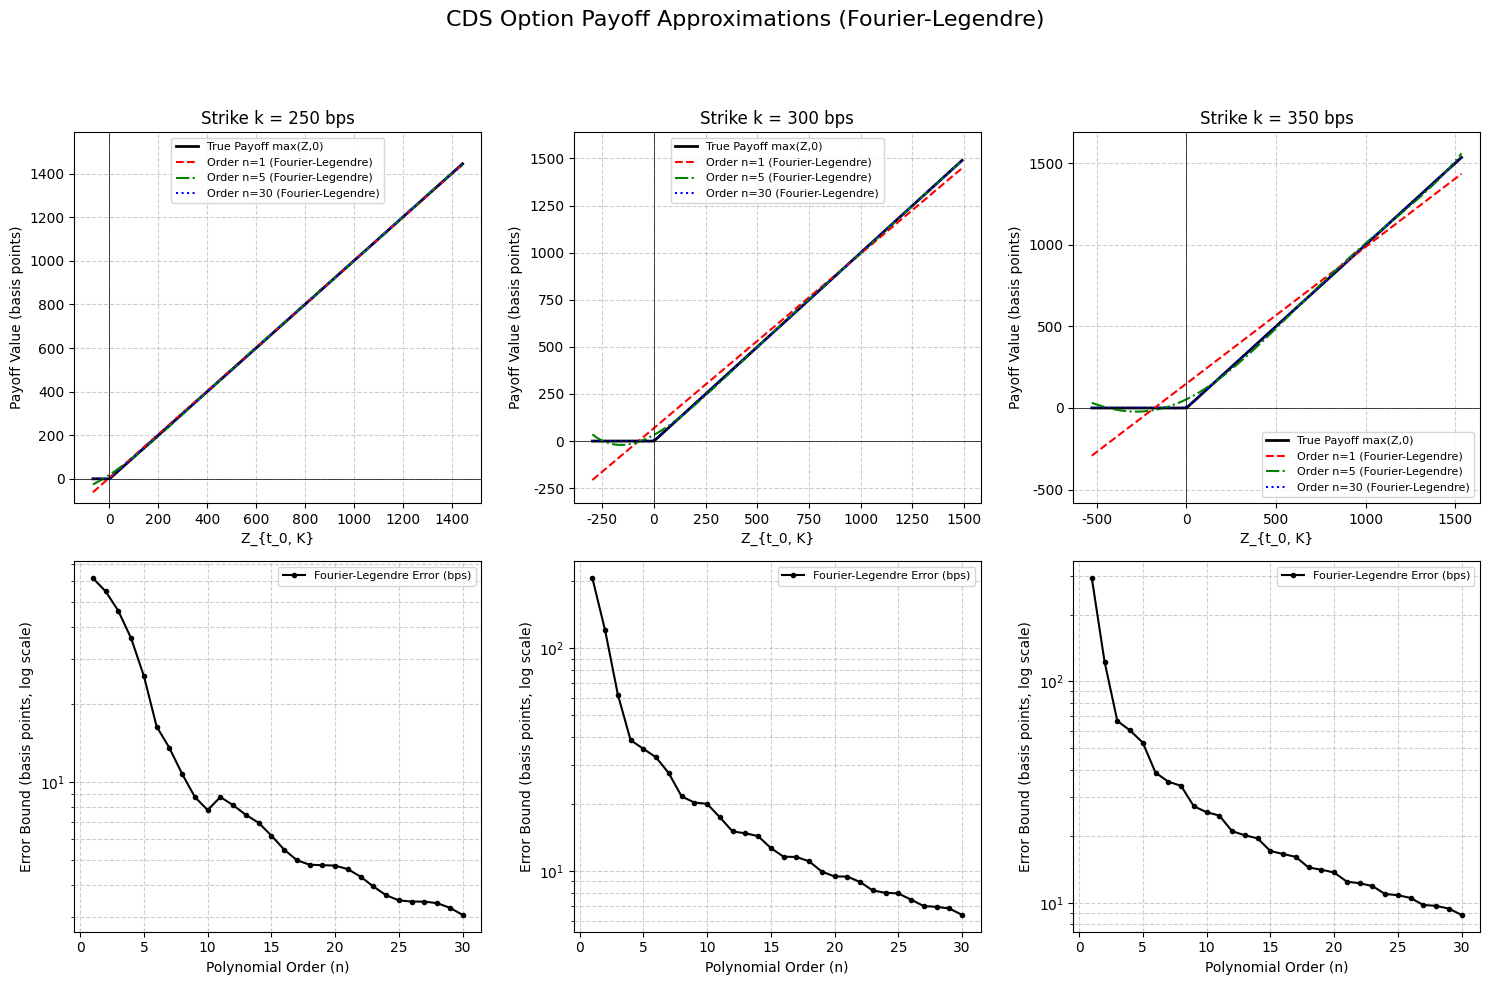

In [195]:
# Setup for the plot
orders_to_plot_payoff = [1, 5, 30]
orders_for_error_bound = range(1, 31) # n from 1 to 30

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(
    "CDS Option Payoff Approximations (Fourier-Legendre)", 
    fontsize=16
)

# Conversion factor from decimal to basis points
DEC_TO_BPS = 10000

# Loop through each strike price 
for i, k_bps in enumerate(strikes_bps):
    strike_dec = strikes[i]
    
    # --- 1. Get bounds for the current strike (in decimal) ---
    b_min_dec, b_max_dec, _ = calculate_cds_payoff_bounds(
        strike=strike_dec,
        t0=t0,
        t_M=tM
    )
    current_bounds_dec = (b_min_dec, b_max_dec)

    # --- Plot for the top row: Payoff Approximation ---
    ax_top = axes[0, i]
    
    # Create a grid of Z-points (in decimal) for evaluation
    z_grid_dec = np.linspace(b_min_dec, b_max_dec, 500)
    
    # Calculate true payoff (in decimal)
    true_payoff_dec = np.maximum(0, z_grid_dec)
    
    # Convert values to basis points for plotting
    z_grid_bps = z_grid_dec * DEC_TO_BPS
    true_payoff_bps = true_payoff_dec * DEC_TO_BPS
    
    ax_top.plot(z_grid_bps, true_payoff_bps, 'k-', label='True Payoff max(Z,0)', linewidth=2)
    
    # Plot approximations for specified orders
    colors = {1: 'r', 5: 'g', 30: 'b'}
    linestyles = {1: '--', 5: '-.', 30: ':'}
    for n_order in orders_to_plot_payoff:
        # Approximate payoff using decimal values (function expects this)
        approx_payoff_dec = approximate_payoff(z_grid_dec, n_order, current_bounds_dec)
        # Convert approximation result to basis points for plotting
        approx_payoff_bps = approx_payoff_dec * DEC_TO_BPS
        ax_top.plot(z_grid_bps, approx_payoff_bps,
                    color=colors[n_order],
                    linestyle=linestyles[n_order],
                    label=f'Order n={n_order} (Fourier-Legendre)')

    ax_top.set_title(f"Strike k = {k_bps} bps")
    ax_top.set_xlabel("Z_{t_0, K}") # Updated X-axis label
    ax_top.set_ylabel("Payoff Value (basis points)") # Updated Y-axis label
    ax_top.grid(True, linestyle='--', alpha=0.6)
    ax_top.axhline(0, color='black', linewidth=0.5)
    ax_top.axvline(0, color='black', linewidth=0.5)
    
    # Set y-limits to be consistent and show the interesting parts (in basis points)
    # Adjusting based on decimal bounds, then converting to bps
    y_min_limit_bps = (min(b_min_dec, -0.01) * 1.1) * DEC_TO_BPS if b_min_dec < 0 else (-0.01 * 1.1) * DEC_TO_BPS
    y_max_limit_bps = (b_max_dec * 1.1) * DEC_TO_BPS
    ax_top.set_ylim(y_min_limit_bps, y_max_limit_bps)
    ax_top.legend(fontsize=8) # Add legend to each subplot for clarity

    # --- Plot for the bottom row: Error Bound vs. Order n ---
    ax_bottom = axes[1, i]
    
    error_bounds_bps = [] # Store errors in basis points
    # Pre-calculate true payoff on a fine grid for error calculation (in decimal)
    error_z_grid_dec = np.linspace(b_min_dec, b_max_dec, 1000)
    error_true_payoff_dec = np.maximum(0, error_z_grid_dec)

    print(f"Calculating Fourier-Legendre error bounds for k = {k_bps} bps...")
    for n in tq.tqdm(orders_for_error_bound, desc=f"n for k={k_bps}"):
        # Approximate payoff using decimal values
        approx_payoff_for_error_dec = approximate_payoff(error_z_grid_dec, n, current_bounds_dec)
    
        # Calculate the uniform error (L-infinity norm) in decimal
        error_decimal = np.max(np.abs(error_true_payoff_dec - approx_payoff_for_error_dec))
    
        # Convert error to basis points for plotting
        error_bps = error_decimal * DEC_TO_BPS
        error_bounds_bps.append(error_bps)

    # Plotting using a log scale for the Y-axis to match the paper's appearance
    ax_bottom.plot(orders_for_error_bound, error_bounds_bps, 'k.-', label='Fourier-Legendre Error (bps)')

    ax_bottom.set_yscale('log') # Changed to log scale as per paper's visual style
    ax_bottom.set_ylabel("Error Bound (basis points, log scale)") # Updated Y-axis label
    ax_bottom.set_xlabel("Polynomial Order (n)") # Added X-axis label
    ax_bottom.grid(True, which="both", linestyle='--', alpha=0.6)
    ax_bottom.legend(fontsize=8)

# Final adjustments for the entire figure 
plt.tight_layout(rect=[0, 0, 1, 0.93]) # Adjust for suptitle
plt.show()

## Calculate Moments

In [196]:
# manage basis indexing
def get_basis_map(n_order):
    """Creates a map from (i,j) exponent tuple to basis index."""
    basis_map = {}
    index = 0
    for total_degree in range(n_order + 1):
        for i in range(total_degree + 1):
            j = total_degree - i
            basis_map[(i, j)] = index
            index += 1
    return basis_map

In [197]:
def calculate_moments_YX(n_order, t):
    """
    Calculates all moments E[Y_t^i * X_t^j|F_t] for i+j <= n_order.
    
    Args:
        n_order (int): The maximum order of the moments.
        t (float): The time horizon (e.g., t0).

    Returns:
        dict: A dictionary mapping exponent tuples (i,j) to moment values.
    """
    
    beta = -(l1 + l2)
    b = (l1 * l2) / gamma
    
    basis_map = get_basis_map(n_order)
    num_basis = len(basis_map)
    inv_basis_map = {v: k for k, v in basis_map.items()} # Inverse map
    
    G_n = np.zeros((num_basis, num_basis))
    
    # Construct the generator matrix G_n
    for k in range(num_basis):
        i, j = inv_basis_map[k] # Get exponents for the k-th basis function y^i * x^j
        
        # Apply the generator G to y^i * x^j
        # G(p) = (-iγ)y^{i-1}x^{j+1} + (jb + 0.5σ²j(j-1))y^{i+1}x^{j-1} + (jβ - 0.5σ²j(j-1))y^ix^j
        
        # Term 1: y^(i-1) * x^(j+1)
        if i > 0 and (i-1 + j+1) <= n_order:
            target_idx = basis_map[(i - 1, j + 1)]
            G_n[target_idx, k] += -i * gamma

        # Term 2: y^(i+1) * x^(j-1)
        if j > 0 and (i+1 + j-1) <= n_order:
            target_idx = basis_map[(i + 1, j - 1)]
            G_n[target_idx, k] += j * b + 0.5 * sigma**2 * j * (j - 1)
            
        # Term 3: y^i * x^j
        if j > 0: # This term exists only if j>0
            target_idx = basis_map[(i, j)]
            G_n[target_idx, k] += j * beta - 0.5 * sigma**2 * j * (j - 1)
        elif j==0 and i>0: # for j=0, only the first term contributes but we handle above
            pass

    # Calculate the matrix exponential
    exp_Gn_t = expm(G_n * t)
    
    # Calculate initial state vector H_n(Y0, X0)
    h0 = np.zeros(num_basis)
    for k in range(num_basis):
        i, j = inv_basis_map[k]
        h0[k] = (Y0**i) * (X0**j)
        
    # Calculate E[p(Y_t, X_t)|F_t] = H_n(Y_t,X_t)
    # where H_n(Y_t,X_t) = exp(G_n*t)^T @ H_n(Y0,X0)
    moments_vec = exp_Gn_t.T @ h0
    
    # Store moments in a dictionary for easy access
    moments_dict = {}
    for k in range(num_basis):
        i, j = inv_basis_map[k]
        moments_dict[(i, j)] = moments_vec[k]
        
    return moments_dict

In [198]:
def calculate_moments_Z(n_order, psi_cds, moments_YX):
    """
    Calculates the moments E[Z^m] for m=1 to n_order, using the recursive
    approach implied by Lemma 4.4 from the article.

    Args:
        n_order (int): The maximum order of the Z moments to calculate.
        psi_cds (np.ndarray): The 2x1 payoff vector for Z.
        moments_YX (dict): Dictionary of (Y,X) moments from the previous step.
        
    Returns:
        np.ndarray: An array of Z moments [E[Z], E[Z^2], ..., E[Z^n_order]].
    """
    psi1 = psi_cds[0, 0]
    psi2 = psi_cds[1, 0]
    
    # Use memoization (caching) to make the recursion efficient
    @functools.lru_cache(maxsize=None)
    def get_C(alpha_y, alpha_x):
        """Recursively calculates the coefficient C(alpha_y, alpha_x)."""
        # Base case
        if alpha_y == 0 and alpha_x == 0:
            return 1.0
        
        # Recursive step
        term1 = 0.0
        if alpha_y > 0:
            term1 = get_C(alpha_y - 1, alpha_x) * psi1
            
        term2 = 0.0
        if alpha_x > 0:
            term2 = get_C(alpha_y, alpha_x - 1) * psi2
            
        return term1 + term2

    Z_moments = np.zeros(n_order)
    
    # Calculate E[Z^m] for each order m
    for m in range(1, n_order + 1):
        E_Zm = 0.0
        # Sum over all partitions of m into alpha_y and alpha_x
        # i.e., alpha_y + alpha_x = m
        for alpha_y in range(m + 1):
            alpha_x = m - alpha_y
            
            # Coefficient C(alpha_y, alpha_x)
            C_alpha = get_C(alpha_y, alpha_x)
            
            # The (Y,X) moment E[Y^alpha_y * X^alpha_x]
            moment_YX = moments_YX.get((alpha_y, alpha_x), 0)
            
            E_Zm += C_alpha * moment_YX
            
        Z_moments[m-1] = E_Zm
        
    return Z_moments

In [199]:
# --- Verification for Moment Calculation ---

# Choose a maximum order
n_order_test = 5

# 1. Calculate the (Y,X) moments at time t0
print(f"Calculating (Y,X) moments up to order {n_order_test} at t={t0}...")
moments_YX_dict = calculate_moments_YX(n_order_test, t0)
print("Done.")
# print("\n(Y,X) Moments:", moments_YX_dict)

# 2. Get the psi_cds vector for a specific strike
strike_test_bps = 250
strike_test_dec = strike_test_bps / 10000.0
_, _, psi_cds_test = calculate_cds_payoff_bounds(strike_test_dec, t0, tM)

# 3. Calculate the Z moments
print(f"\nCalculating Z moments for k={strike_test_bps} bps...")
Z_moments_arr = calculate_moments_Z(n_order_test, psi_cds_test, moments_YX_dict)
print("Done.")

# Print the Z moments
for m in range(len(Z_moments_arr)):
    print(f"E[Z^{m+1}] = {Z_moments_arr[m]:.6f}")

Calculating (Y,X) moments up to order 5 at t=1.0...
Done.

Calculating Z moments for k=250 bps...
Done.
E[Z^1] = 0.021041
E[Z^2] = 0.001045
E[Z^3] = 0.000063
E[Z^4] = 0.000004
E[Z^5] = 0.000000


## Calculate Option Prices

In [200]:
def get_legendre_coeffs_on_interval(n, bounds):
    """
    Gets the coefficients of the nth generalized Legendre polynomial Le_n(z)
    in the standard power basis, i.e., Le_n(z) = Σ d_j * z^j.

    Args:
        n (int): Order of the polynomial.
        bounds (tuple): The interval [b_min, b_max].

    Returns:
        np.poly1d: A numpy polynomial object representing Le_n(z).
    """
    b_min, b_max = bounds
    # The standard Legendre polynomial P_n(x)
    Pn = legendre(n)
    
    # We need to express Le_n(z) = P_n((2z-a-b)/(b-a)) as a polynomial in z.
    # Let x = g(z) = mz + c, where m=2/(b-a), c=-(a+b)/(b-a)
    # We need to compute the composition P_n(g(z)).
    # np.poly1d objects handle this composition automatically.
    m = 2 / (b_max - b_min)
    c = -(b_max + b_min) / (b_max - b_min)
    g = np.poly1d([m, c]) # Represents the linear transformation g(z)
    
    Le_n = Pn(g) # This computes the composition and returns a new polynomial in z
    return Le_n

In [201]:
def calculate_option_price(n_order, strike, t0, tM):
    """
    Calculates the CDS option price using n-order polynomial approximation.

    Args:
        n_order (int): The order of the polynomial approximation.
        strike (float): The strike spread (decimal).
        t0 (float): Option maturity.
        tM (float): Underlying CDS maturity.

    Returns:
        float: The approximated option price.
    """
    # 1. Get bounds and psi_cds for the given strike
    b_min, b_max, psi_cds = calculate_cds_payoff_bounds(strike, t0, tM)
    bounds = (b_min, b_max)
    
    # 2. Calculate Fourier-Legendre coefficients for the payoff
    f_coeffs = [calculate_fourier_legendre_coeff(i, bounds) for i in range(n_order + 1)]
    
    # 3. Calculate (Y,X) moments up to the required order
    # Note: We need Z moments up to n_order, which requires (Y,X) moments up to n_order
    moments_YX = calculate_moments_YX(n_order, t0)
    
    # 4. Calculate Z moments
    # Note: The result from this function is [E[Z], E[Z^2], ...], so need to prepend E[Z^0]=1
    Z_moments_raw = calculate_moments_Z(n_order, psi_cds, moments_YX)
    # E_Z_pow_j[j] will store E[Z^j]. So E_Z_pow_j[0] = 1.
    E_Z_pow_j = np.insert(Z_moments_raw, 0, 1.0) 
    
    # 5. Calculate the final price by summing f_i * E[Le_i(Z)]
    total_price = 0.0
    for i, f_i in enumerate(f_coeffs):
        # Get the polynomial Le_i(z) = Σ d_j * z^j
        Le_i = get_legendre_coeffs_on_interval(i, bounds)
        # Its coefficients are [d_i, d_{i-1}, ..., d_0]
        d_coeffs = Le_i.coeffs
        
        # Calculate E[Le_i(Z)] = Σ d_j * E[Z^j]
        # Note: numpy poly coeffs are from highest power to lowest.
        E_Le_i = 0.0
        for j, d_j in enumerate(reversed(d_coeffs)): # reversed gives d_0, d_1, ...
            E_Le_i += d_j * E_Z_pow_j[j]
            
        total_price += f_i * E_Le_i
    # for i, f_i in enumerate(f_coeffs):
    #     E_Le_i = expected_legendre(i, b_min, b_max, E_Z_pow_j)
    #     total_price += f_i * E_Le_i

        
    # Final step: The price is an expectation, but the payoff itself has pre-factors.
    # V_CDSO = E[e^{-r(t0-t)} * 1_{τ>t0} * (V_CDS)^+]
    # (V_CDS)^+ = (1/S_{t0}) * Z^+ ≈ (1/Y_{t0}) * p_n(Z)
    # The actual calculation is more complex. The paper's formulation E[f(Z(t0,...))]
    # seems to imply the price is directly E[p_n(Z)]. Let's follow this simplified path.
    # Discounting should be applied.
    price = np.exp(-r * t0) * total_price
    
    return price

In [202]:
def debug_moments_and_expectations(n_order, strike, t0, tM):
    print("="*60)
    print(f"Debugging for n={n_order}, strike={strike*10000:.0f} bps")
    print("="*60)

    # 1. payoff bounds + psi
    b_min, b_max, psi_cds = calculate_cds_payoff_bounds(strike, t0, tM)
    print(f"[Bounds] b_min={b_min:.6f}, b_max={b_max:.6f}")
    print(f"[psi_cds] = {psi_cds.ravel()}")

    # 2. moments Y,X
    moments_YX = calculate_moments_YX(n_order, t0)
    print("First few (Y,X) moments:")
    for k in sorted(moments_YX.keys())[:5]:
        print(f"  E[Y^{k[0]} X^{k[1]}] = {moments_YX[k]}")

    # 3. Z-moments
    Z_moments = calculate_moments_Z(n_order, psi_cds, moments_YX)
    EZ_pow = np.insert(Z_moments, 0, 1.0)  # prepend E[Z^0]=1
    print("First few Z-moments:")
    for m in range(1, min(6, len(EZ_pow))):
        print(f"  E[Z^{m}] = {EZ_pow[m]}")

    # 4. Fourier–Legendre coefficients
    coeffs = [calculate_fourier_legendre_coeff(i, (b_min, b_max)) for i in range(n_order+1)]
    print("First few Fourier-Legendre coeffs a_n:")
    for i,a in enumerate(coeffs[:6]):
        print(f"  a_{i} = {a}")

    # 5. Expected Le_n(Z)
    for i in range(1, min(6, n_order+1)):
        Le_i = get_legendre_coeffs_on_interval(i, (b_min, b_max))
        d_coeffs = Le_i.coeffs
        E_Le_i = 0.0
        for j, d_j in enumerate(reversed(d_coeffs)):
            if j < len(EZ_pow):
                E_Le_i += d_j * EZ_pow[j]
        print(f"  E[Le_{i}(Z)] = {E_Le_i}")

    # 6. Approximate option price (sum of coeff*expectation)
    approx_price = 0.0
    for i, f_i in enumerate(coeffs):
        Le_i = get_legendre_coeffs_on_interval(i, (b_min, b_max))
        d_coeffs = Le_i.coeffs
        E_Le_i = 0.0
        for j, d_j in enumerate(reversed(d_coeffs)):
            if j < len(EZ_pow):
                E_Le_i += d_j * EZ_pow[j]
        approx_price += f_i * E_Le_i

    price_bps = np.exp(-r*t0) * approx_price * 10000
    print(f"[Option price approx] {price_bps:.6f} bps")
    print("="*60)

In [203]:
debug_moments_and_expectations(30, strikes[0], t0, tM)

Debugging for n=30, strike=250 bps
[Bounds] b_min=-0.006775, b_max=0.144475
[psi_cds] = [-0.00677512  0.1444752 ]
First few (Y,X) moments:
  E[Y^0 X^0] = 1.0
  E[Y^0 X^1] = 0.19024588490014194
  E[Y^0 X^2] = 0.06472814463543353
  E[Y^0 X^3] = 0.02815970601085774
  E[Y^0 X^4] = 0.014127558570613664
First few Z-moments:
  E[Z^1] = 0.021041120381899505
  E[Z^2] = 0.001045245744277489
  E[Z^3] = 6.264317441466636e-05
  E[Z^4] = 4.3427412061597366e-06
  E[Z^5] = 3.304507399743216e-07
First few Fourier-Legendre coeffs a_n:
  a_0 = 0.06900178380955248
  a_1 = 0.07518352416203639
  a_2 = 0.0006922654791135828
  a_3 = -0.0008823448156641913
  a_4 = 0.0009972653971425777
  a_5 = -0.0010305804449613279
  E[Le_1(Z)] = -0.6321827417356912
  E[Le_2(Z)] = 0.25750831514213135
  E[Le_3(Z)] = -0.0944628197146612
  E[Le_4(Z)] = 0.06241703642188179
  E[Le_5(Z)] = -0.04921464421421873
[Option price approx] 205.348893 bps


In [204]:
# Orders for error bound are N_orders
orders_for_error_bound = N_orders

price_results = {k: [] for k in strikes_bps}
cpu_times = []
detailed_price_output = [] # Store detailed results for DataFrame

print("="*50)
print("Calculating option prices for Figure 7...")
print("="*50)

for n in tq.tqdm(orders_for_error_bound, desc="Approximation Order n"):
    start_time = time.time()
    
    current_n_prices = {'Order_n': n} # Dictionary to store prices for current n
    
    # Calculate price for each strike at the current order n
    for i, k_bps in enumerate(strikes_bps):
        strike_dec = strikes[i] # Get decimal strike value
        price = calculate_option_price(n, strike_dec, t0, tM)
        
        # Convert price to basis points and store
        price_bps = price * 10000
        price_results[k_bps].append(price_bps)
        current_n_prices[f'Strike_{k_bps}_bps'] = price_bps
        
    detailed_price_output.append(current_n_prices) # Add current n's prices to the list
        
    end_time = time.time()
    cpu_times.append(end_time - start_time)

print("\nCalculation complete.")

# --- Output detailed price table before plotting ---
df_detailed_prices = pd.DataFrame(detailed_price_output)
print("\n--- Detailed Option Price Output (in basis points) ---")
# Use to_string to print the full DataFrame without truncation
print(df_detailed_prices.to_string(index=False, float_format='%.6f'))
print("\n") # Add a newline for separation


Calculating option prices for Figure 7...


Approximation Order n: 100%|██████████| 30/30 [01:04<00:00,  2.15s/it]


Calculation complete.

--- Detailed Option Price Output (in basis points) ---
 Order_n  Strike_250_bps  Strike_300_bps  Strike_350_bps
       1      214.720574       68.976531      -26.400395
       2      216.503215       94.113784       33.720893
       3      217.336703      101.762496       46.590344
       4      217.959166      104.355566       47.918997
       5      218.466363      105.117589       47.218424
       6      218.829175      104.969450       46.715166
       7      219.080894      104.730785       46.726035
       8      219.237422      104.637562       46.625583
       9      219.325245      104.645633       46.324423
      10      219.366120      104.620529       46.146282
      11      219.376837      104.529108       46.312885
      12      219.371821      104.425016       46.632393
      13      219.360876      104.389909       46.779902
      14      219.350347      104.447217       46.645148
      15      219.342841      104.555448       46.414183
      16 

Calculating option prices for Figure 7...


Approximation Order n: 100%|██████████| 30/30 [01:02<00:00,  2.10s/it]



Calculation complete.


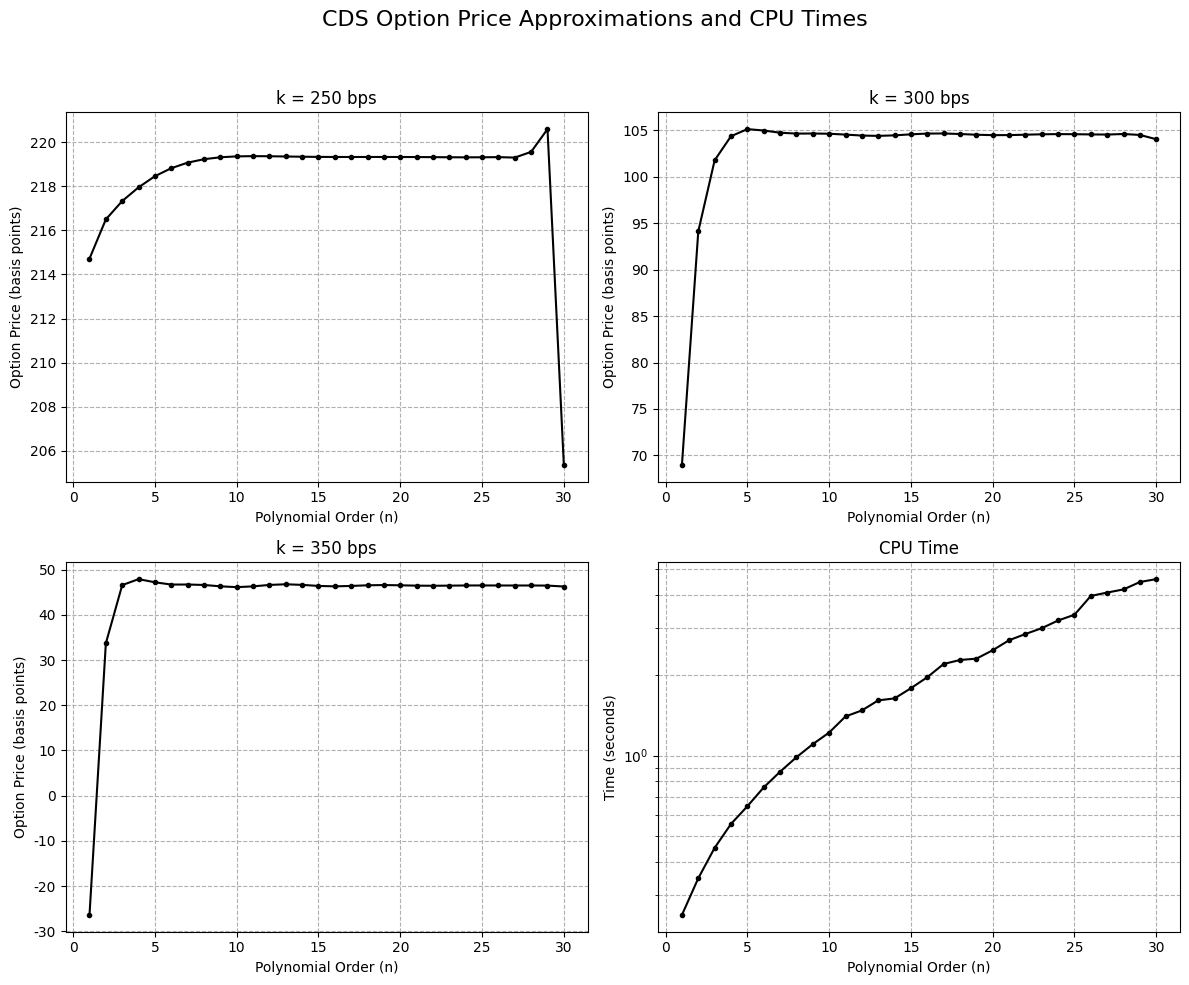

In [205]:
price_results = {k: [] for k in strikes_bps}
cpu_times = []

print("="*50)
print("Calculating option prices for Figure 7...")
print("="*50)

for n in tq.tqdm(orders_for_error_bound, desc="Approximation Order n"):
    start_time = time.time()
    
    # Calculate price for each strike at the current order n
    for i, k_bps in enumerate(strikes_bps):
        price = calculate_option_price(n, strikes[i], t0, tM)
        # Convert price to basis points for plotting
        price_results[k_bps].append(price * 10000)
        
    end_time = time.time()
    cpu_times.append(end_time - start_time)

print("\nCalculation complete.")

# --- Plotting Figure 7 ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("CDS Option Price Approximations and CPU Times", fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot prices vs. order for each strike
plot_map = {250: 0, 300: 1, 350: 2} # Map strike to subplot index
for k_bps, prices in price_results.items():
    ax = axes[plot_map[k_bps]]
    ax.plot(orders_for_error_bound, prices, 'k.-')
    ax.set_title(f"k = {k_bps} bps")
    ax.set_xlabel("Polynomial Order (n)")
    ax.set_ylabel("Option Price (basis points)")
    ax.grid(True, linestyle='--')

# Plot CPU time vs. order
ax_cpu = axes[3]
ax_cpu.plot(orders_for_error_bound, cpu_times, 'k.-')
ax_cpu.set_title("CPU Time")
ax_cpu.set_xlabel("Polynomial Order (n)")
ax_cpu.set_ylabel("Time (seconds)")
ax_cpu.set_yscale('log') # CPU time often grows polynomially, log scale is good
ax_cpu.grid(True, which="both", linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()